# Limpieza de datos para valores relacionados al pitch

Para este notebook, se busca la limpieza completa de todas las variables relacionadas al lanzamiento del pitcher, esto para luego determinar la categoría del pitch.

---

## Columnas relacionadas al lanzamiento

In [1]:
pitch_columns_extended = [
    # Target
    'pitch_type', 'pitch_name', 'pitch_number',

    # Física del lanzamiento
    'release_speed', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed',

    # Spin y break
    'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z',
    'api_break_z_with_gravity', 'api_break_x_arm',

    # Mecánica del brazo
    'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'p_throws',

    # Contexto de juego
    'balls', 'strikes', 'outs_when_up', 'inning', 'inning_topbot',
    'home_score', 'away_score', 'bat_score', 'fld_score', 'on_1b', 'on_2b', 'on_3b',

    # Defensiva (opcional)
    'pitcher', 'fielder_2',

    # Zona de impacto (opcional)
    'plate_x', 'plate_z', 'zone'
]

---

## Obtención de los datos

In [2]:
# Años a procesar
start_year = 2023
end_year = 2024

In [3]:
exec(open('../src/csv_manager.py').read())

df_combined = append_csv('statcast_raw_data', start_year, end_year)

Datos leídos desde: ../data/statcast_raw_data/statcast_2023.csv con 771057 filas y 118 columnas
Datos leídos desde: ../data/statcast_raw_data/statcast_2024.csv con 757714 filas y 118 columnas
Datos leídos desde: ../data/statcast_raw_data/statcast_2024.csv con 757714 filas y 118 columnas
Datos combinados: 1528771 filas y 118 columnas en total
Datos combinados: 1528771 filas y 118 columnas en total


In [4]:
df_combined_pitch = df_combined[pitch_columns_extended].copy()

---
## Categóricas

### Pitch type

In [5]:
# Reemplazar NaN por 'UN' en "pitch_type" y convertir a categoría
df_combined_pitch["pitch_type"] = df_combined_pitch["pitch_type"].fillna('UN').astype('category')

# Revisar si quedaron NaN en "pitch_type" y mostrar el tipo de dato
print("\nVerificación de la columna 'pitch_type' después de la limpieza:")
print(df_combined_pitch['pitch_type'].value_counts())
print(f"\nTipo de dato de 'pitch_type': {df_combined_pitch['pitch_type'].dtype}")


Verificación de la columna 'pitch_type' después de la limpieza:
pitch_type
FF    480467
SL    234751
SI    234046
CH    157638
FC    120262
CU     96639
ST     94139
FS     39923
UN     30105
KC     28859
SV      6327
FA      1746
KN      1253
EP      1133
FO       969
SC       276
CS       134
PO       104
Name: count, dtype: int64

Tipo de dato de 'pitch_type': category


### Pitch name

In [6]:
# Reemplazar NaN por 'Unknown' en "pitch_name" y convertir a categoría
df_combined_pitch["pitch_name"] = df_combined_pitch["pitch_name"].fillna('Unknown').astype('category')

# Revisar si quedaron NaN en "pitch_name" y mostrar el tipo de dato
print("\nVerificación de la columna 'pitch_name' después de la limpieza:")
print(df_combined_pitch['pitch_name'].value_counts())
print(f"\nTipo de dato de 'pitch_name': {df_combined_pitch['pitch_name'].dtype}")



Verificación de la columna 'pitch_name' después de la limpieza:
pitch_name
4-Seam Fastball    480467
Slider             234751
Sinker             234046
Changeup           157638
Cutter             120262
Curveball           96639
Sweeper             94139
Split-Finger        39923
Unknown             30105
Knuckle Curve       28859
Slurve               6327
Other                1746
Knuckleball          1253
Eephus               1133
Forkball              969
Screwball             276
Slow Curve            134
Pitch Out             104
Name: count, dtype: int64

Tipo de dato de 'pitch_name': category


### Pitch number

In [7]:
# Revisar pitch_number valores unicos y tipo de dato (include NaN)
print("\nVerificación de la columna 'pitch_number' después de la limpieza:")
print(df_combined_pitch['pitch_number'].value_counts(dropna=False))
print(f"\nTipo de dato de 'pitch_number': {df_combined_pitch['pitch_number'].dtype}")


Verificación de la columna 'pitch_number' después de la limpieza:
pitch_number
1     398609
2     346869
3     288715
4     217312
5     144249
6      79628
7      33024
8      12847
9       4761
10      1778
11       617
12       233
13        83
14        32
15        10
16         4
Name: count, dtype: int64

Tipo de dato de 'pitch_number': int64


### Inning top or bot

In [8]:
df_combined_pitch['inning_topbot'] = df_combined_pitch['inning_topbot'].astype('category')

### Hand Throws

In [9]:
df_combined_pitch['p_throws'] = df_combined_pitch['p_throws'].astype('category')

---

## Valores númericos

### Optimización de variables

In [10]:
def optimize_numeric_dtypes(df):
    """
    Reduce memory usage by downcasting numeric columns to smaller types
    """ 
    # Columnas int
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        # Verificar rango de valores
        col_min = df[col].min()
        col_max = df[col].max()
        
        # Elegir el tipo más pequeño que pueda contener los valores
        if col_min >= 0:  # Unsigned
            if col_max < 256:
                df[col] = df[col].astype('uint8')
            elif col_max < 65536:
                df[col] = df[col].astype('uint16')
            elif col_max < 4294967296:
                df[col] = df[col].astype('uint32')
        else:  # Signed
            if col_min >= -128 and col_max < 128:
                df[col] = df[col].astype('int8')
            elif col_min >= -32768 and col_max < 32768:
                df[col] = df[col].astype('int16')
            elif col_min >= -2147483648 and col_max < 2147483648:
                df[col] = df[col].astype('int32')
    
    return df

In [11]:
df_combined_pitch = optimize_numeric_dtypes(df_combined_pitch)

### Rellenar datos NaN de variables con medias (y creación de bools)

In [12]:
import numpy as np
import pandas as pd

def impute_by_pitcher(df, cols, group_col='pitcher', min_count=5):
    # precomputos por pitcher
    counts = df.groupby(group_col)[cols].count()  # cuántos no-NaN por col
    means  = df.groupby(group_col)[cols].mean()

    for col in cols:
        # 1) flag antes de imputar
        df[f'{col}_missing'] = df[col].isna()

        # 2) medias válidas solo para pitchers con suficiente conteo
        valid_pitchers = counts.index[counts[col] >= min_count]
        map_means = means[col].reindex(valid_pitchers)

        # 3) imputación por pitcher (map sin inplace)
        df[col] = df[col].fillna(df[group_col].map(map_means))

        # 4) imputación global para rezagos
        global_mean = df[col].mean(skipna=True)
        df[col] = df[col].fillna(global_mean)

    return df


In [13]:
num_cols = [
    'release_speed', 'release_spin_rate', 'spin_axis', 'effective_speed',
    'release_extension', 'api_break_z_with_gravity', 'az', 'ay', 'ax',
    'pfx_z', 'release_pos_y', 'pfx_x', 'vz0', 'release_pos_z',
    'release_pos_x', 'api_break_x_arm', 'zone', 'plate_x', 'plate_z',
    'vy0', 'vx0'
]

In [14]:
df_combined_pitch = impute_by_pitcher(df_combined_pitch, num_cols)

#### On_base

In [15]:
# Crear banderas para on_base
df_combined_pitch['has_1b'] = df_combined_pitch['on_1b'].notna()
df_combined_pitch['has_2b'] = df_combined_pitch['on_2b'].notna()
df_combined_pitch['has_3b'] = df_combined_pitch['on_3b'].notna()

# Cambiar NaN por 0 en on_base
df_combined_pitch['on_1b'] = df_combined_pitch['on_1b'].fillna(0).astype(int)
df_combined_pitch['on_2b'] = df_combined_pitch['on_2b'].fillna(0).astype(int)
df_combined_pitch['on_3b'] = df_combined_pitch['on_3b'].fillna(0).astype(int)

---

## Comprobación final

In [16]:
# Verificar cantidad de nulos restantes
print("\n=== Cantidad de valores nulos restantes por columna ===")
nulos_restantes = df_combined_pitch.isnull().sum()
for columna, nulos in nulos_restantes.items():
    print(f"{columna}:\t{nulos} valores nulos restantes")


=== Cantidad de valores nulos restantes por columna ===
pitch_type:	0 valores nulos restantes
pitch_name:	0 valores nulos restantes
pitch_number:	0 valores nulos restantes
release_speed:	0 valores nulos restantes
vx0:	0 valores nulos restantes
vy0:	0 valores nulos restantes
vz0:	0 valores nulos restantes
ax:	0 valores nulos restantes
ay:	0 valores nulos restantes
az:	0 valores nulos restantes
effective_speed:	0 valores nulos restantes
release_spin_rate:	0 valores nulos restantes
spin_axis:	0 valores nulos restantes
pfx_x:	0 valores nulos restantes
pfx_z:	0 valores nulos restantes
api_break_z_with_gravity:	0 valores nulos restantes
api_break_x_arm:	0 valores nulos restantes
release_pos_x:	0 valores nulos restantes
release_pos_y:	0 valores nulos restantes
release_pos_z:	0 valores nulos restantes
release_extension:	0 valores nulos restantes
p_throws:	0 valores nulos restantes
balls:	0 valores nulos restantes
strikes:	0 valores nulos restantes
outs_when_up:	0 valores nulos restantes
innin

In [17]:
# Comprobar los valores únicos por cada columna en una lista
print("\n=== Valores únicos por columna ===")
for columna in df_combined_pitch.columns:
    valores_unicos = df_combined_pitch[columna].unique()
    print(f"{columna}:\t{valores_unicos}")


=== Valores únicos por columna ===
pitch_type:	['CU', 'FF', 'ST', 'SL', 'SI', ..., 'FA', 'UN', 'FO', 'CS', 'SC']
Length: 18
Categories (18, object): ['CH', 'CS', 'CU', 'EP', ..., 'SL', 'ST', 'SV', 'UN']
pitch_name:	['Curveball', '4-Seam Fastball', 'Sweeper', 'Slider', 'Sinker', ..., 'Other', 'Unknown', 'Forkball', 'Slow Curve', 'Screwball']
Length: 18
Categories (18, object): ['4-Seam Fastball', 'Changeup', 'Curveball', 'Cutter', ..., 'Slurve', 'Split-Finger', 'Sweeper', 'Unknown']
pitch_number:	[ 5  4  3  2  1  6  7  8 10  9 11 15 14 13 12 16]
release_speed:	[84.9        96.6        84.5        ... 89.38007519 88.56350168
 87.00974026]
release_speed:	[84.9        96.6        84.5        ... 89.38007519 88.56350168
 87.00974026]
vx0:	[-0.72686816  4.91360024 -0.48105616 ...  4.27218605 11.32616199
  5.71888073]
vx0:	[-0.72686816  4.91360024 -0.48105616 ...  4.27218605 11.32616199
  5.71888073]
vy0:	[-123.59540567 -140.26118738 -123.00404019 ... -136.38312562 -136.34466024
 -126.547749

In [18]:
# Tipo de dato final por columna
print("\n=== Tipo de dato final por columna ===")
for columna in df_combined_pitch.columns:
    tipo_dato = df_combined_pitch[columna].dtype
    print(f"{columna}:\t{tipo_dato}")


=== Tipo de dato final por columna ===
pitch_type:	category
pitch_name:	category
pitch_number:	uint8
release_speed:	float64
vx0:	float64
vy0:	float64
vz0:	float64
ax:	float64
ay:	float64
az:	float64
effective_speed:	float64
release_spin_rate:	float64
spin_axis:	float64
pfx_x:	float64
pfx_z:	float64
api_break_z_with_gravity:	float64
api_break_x_arm:	float64
release_pos_x:	float64
release_pos_y:	float64
release_pos_z:	float64
release_extension:	float64
p_throws:	category
balls:	uint8
strikes:	uint8
outs_when_up:	uint8
inning:	uint8
inning_topbot:	category
home_score:	uint8
away_score:	uint8
bat_score:	uint8
fld_score:	uint8
on_1b:	int64
on_2b:	int64
on_3b:	int64
pitcher:	uint32
fielder_2:	uint32
plate_x:	float64
plate_z:	float64
zone:	float64
release_speed_missing:	bool
release_spin_rate_missing:	bool
spin_axis_missing:	bool
effective_speed_missing:	bool
release_extension_missing:	bool
api_break_z_with_gravity_missing:	bool
az_missing:	bool
ay_missing:	bool
ax_missing:	bool
pfx_z_missin

In [19]:
# Comprobar canttidad de memoria usada
memoria_usada = df_combined_pitch.memory_usage(deep=True).sum() / (1024 ** 2)
print(f"\nMemoria usada por el DataFrame después de la limpieza: {memoria_usada:.2f} MB")


Memoria usada por el DataFrame después de la limpieza: 345.54 MB


---

## Guardar df como limpio

In [20]:
# Guardar el DataFrame limpio
exec(open('../src/csv_manager.py').read())

create_csv(df_combined_pitch, '../data/statcast_clean_data', start_year=start_year, end_year=end_year)

Datos guardados en: ../data/../data/statcast_clean_data/statcast_2023_to_2024.csv
Archivo creado con 1528771 filas y 63 columnas


---

## Modelo AI - Random Forest

### Preparación de datos para el modelo

In [21]:
# Analizar tipos de datos y columnas problemáticas
print("=== Análisis de tipos de datos ===\n")

# Columnas categóricas
cat_cols = df_combined_pitch.select_dtypes(include=['category', 'object']).columns.tolist()
print(f"Columnas categóricas: {cat_cols}\n")

# Columnas numéricas
num_cols_df = df_combined_pitch.select_dtypes(include=['int8', 'int16', 'int32', 'int64', 
                                                         'uint8', 'uint16', 'uint32', 'uint64',
                                                         'float16', 'float32', 'float64']).columns.tolist()
print(f"Columnas numéricas: {len(num_cols_df)} columnas")

# Columnas booleanas
bool_cols = df_combined_pitch.select_dtypes(include=['bool']).columns.tolist()
print(f"Columnas booleanas: {bool_cols}\n")

print(f"\nTotal de columnas: {len(df_combined_pitch.columns)}")
print(f"Categóricas: {len(cat_cols)}, Numéricas: {len(num_cols_df)}, Booleanas: {len(bool_cols)}")

=== Análisis de tipos de datos ===

Columnas categóricas: ['pitch_type', 'pitch_name', 'p_throws', 'inning_topbot']

Columnas numéricas: 35 columnas
Columnas booleanas: ['release_speed_missing', 'release_spin_rate_missing', 'spin_axis_missing', 'effective_speed_missing', 'release_extension_missing', 'api_break_z_with_gravity_missing', 'az_missing', 'ay_missing', 'ax_missing', 'pfx_z_missing', 'release_pos_y_missing', 'pfx_x_missing', 'vz0_missing', 'release_pos_z_missing', 'release_pos_x_missing', 'api_break_x_arm_missing', 'zone_missing', 'plate_x_missing', 'plate_z_missing', 'vy0_missing', 'vx0_missing', 'has_1b', 'has_2b', 'has_3b']


Total de columnas: 63
Categóricas: 4, Numéricas: 35, Booleanas: 24
Columnas numéricas: 35 columnas
Columnas booleanas: ['release_speed_missing', 'release_spin_rate_missing', 'spin_axis_missing', 'effective_speed_missing', 'release_extension_missing', 'api_break_z_with_gravity_missing', 'az_missing', 'ay_missing', 'ax_missing', 'pfx_z_missing', 'release

In [22]:
# Crear una copia del DataFrame para el modelo
df_model = df_combined_pitch.copy()

# Codificar variables categóricas (excepto pitch_type y pitch_name que son el target)
# p_throws: R (Right) o L (Left)
df_model['p_throws_encoded'] = df_model['p_throws'].cat.codes

# inning_topbot: Top o Bot
df_model['inning_topbot_encoded'] = df_model['inning_topbot'].cat.codes

# Convertir booleanas a enteros (0 o 1)
bool_cols = df_model.select_dtypes(include=['bool']).columns.tolist()
for col in bool_cols:
    df_model[col] = df_model[col].astype(int)

print("✓ Variables categóricas codificadas")
print(f"✓ {len(bool_cols)} columnas booleanas convertidas a int")
print(f"\nColumnas después de la codificación: {len(df_model.columns)}")

✓ Variables categóricas codificadas
✓ 24 columnas booleanas convertidas a int

Columnas después de la codificación: 65


### Entrenar al modelo

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Preparar datos para el modelo
# Excluir las columnas target y las categóricas originales
columns_to_drop = ['pitch_type', 'pitch_name', 'p_throws', 'inning_topbot', 
                   'pitcher', 'fielder_2']  # También excluimos IDs de jugadores

X = df_model.drop(columns=columns_to_drop)
y = df_model['pitch_type']

print(f"Características (X): {X.shape}")
print(f"Target (y): {y.shape}")
print(f"\nColumnas usadas en el modelo: {list(X.columns)}")
print(f"\nClases en el target: {y.cat.categories.tolist()}")
print(f"Distribución de clases:\n{y.value_counts()}")

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"Tamaño del conjunto de prueba: {X_test.shape}")

# Crear y entrenar el modelo
print("\n🔄 Entrenando Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, verbose=1)
rf_model.fit(X_train, y_train)
print("✓ Modelo entrenado exitosamente!")

Características (X): (1528771, 59)
Target (y): (1528771,)

Columnas usadas en el modelo: ['pitch_number', 'release_speed', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'effective_speed', 'release_spin_rate', 'spin_axis', 'pfx_x', 'pfx_z', 'api_break_z_with_gravity', 'api_break_x_arm', 'release_pos_x', 'release_pos_y', 'release_pos_z', 'release_extension', 'balls', 'strikes', 'outs_when_up', 'inning', 'home_score', 'away_score', 'bat_score', 'fld_score', 'on_1b', 'on_2b', 'on_3b', 'plate_x', 'plate_z', 'zone', 'release_speed_missing', 'release_spin_rate_missing', 'spin_axis_missing', 'effective_speed_missing', 'release_extension_missing', 'api_break_z_with_gravity_missing', 'az_missing', 'ay_missing', 'ax_missing', 'pfx_z_missing', 'release_pos_y_missing', 'pfx_x_missing', 'vz0_missing', 'release_pos_z_missing', 'release_pos_x_missing', 'api_break_x_arm_missing', 'zone_missing', 'plate_x_missing', 'plate_z_missing', 'vy0_missing', 'vx0_missing', 'has_1b', 'has_2b', 'has_3b', 'p_throws_encoded

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min


✓ Modelo entrenado exitosamente!


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.1min finished


In [24]:
# Hacer predicciones
y_pred = rf_model.predict(X_test)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    9.6s finished
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    9.6s finished


### Evaluar el modelo

In [25]:
print("\n=== Evaluación del Modelo Random Forest ===")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


=== Evaluación del Modelo Random Forest ===
[[30036     0     1     1     6    19   103     0   420     0     0     0
      0   887    55     0     0     0]
 [    0    10    13     4     0     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [    3     1 17067     2     0     4     8     0     2   209     0     0
      0     4  1173   849     3     3]
 [    0     1     0   207    18     0     0     0     0     0     0     0
      0     0     0     0     0     0]
 [   13     0     1    16   311     0     8     0     0     0     0     0
      0     0     0     0     0     0]
 [   17     0    16     1     0 18329  1220     0     6     0     0     0
      0    79  4273   109     0     2]
 [   79     0     1     0     2   886 93645     0     2     0     0     0
      0  1440    31     0     0     8]
 [   20     0     1     0     0     0     0    86    87     0     0     0
      0     0     0     0     0     0]
 [ 1784     0     0     0     0    10    31     1  

/home/senna/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/senna/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/senna/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score   support

          CH       0.92      0.95      0.93     31528
          CS       0.83      0.37      0.51        27
          CU       0.88      0.88      0.88     19328
          EP       0.88      0.92      0.90       226
          FA       0.91      0.89      0.90       349
          FC       0.83      0.76      0.79     24052
          FF       0.96      0.97      0.97     96094
          FO       0.99      0.44      0.61       194
          FS       0.91      0.75      0.82      7985
          KC       0.92      0.66      0.77      5772
          KN       0.98      0.91      0.95       251
          PO       0.00      0.00      0.00        21
          SC       0.98      0.73      0.83        55
          SI       0.94      0.93      0.94     46809
          SL       0.84      0.88      0.86     46950
          ST       0.83      0.88      0.85     18828
          SV       0.97      0.55      0.70      1265
          UN       1.00    

In [26]:
from sklearn.metrics import accuracy_score, f1_score

# Calcular métricas generales
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("=== Métricas Generales del Modelo ===\n")
print(f"Accuracy (Precisión general): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"F1-Score (Macro): {f1_macro:.4f}")
print(f"F1-Score (Weighted): {f1_weighted:.4f}")

# Score del modelo
train_score = rf_model.score(X_train, y_train)
test_score = rf_model.score(X_test, y_test)

print(f"\nScore en entrenamiento: {train_score:.4f} ({train_score*100:.2f}%)")
print(f"Score en prueba: {test_score:.4f} ({test_score*100:.2f}%)")

# Verificar overfitting
overfitting_diff = train_score - test_score
print(f"\nDiferencia (posible overfitting): {overfitting_diff:.4f}")
if overfitting_diff > 0.05:
    print("⚠️  Advertencia: Posible overfitting detectado")
else:
    print("✓ El modelo generaliza bien")

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.0s finished
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    8.0s finished


=== Métricas Generales del Modelo ===

Accuracy (Precisión general): 0.9093 (90.93%)
F1-Score (Macro): 0.7902
F1-Score (Weighted): 0.9082


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   36.5s finished
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   36.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.2s finished
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    7.2s finished



Score en entrenamiento: 1.0000 (100.00%)
Score en prueba: 0.9093 (90.93%)

Diferencia (posible overfitting): 0.0907
⚠️  Advertencia: Posible overfitting detectado


In [27]:
from sklearn.metrics import classification_report

# Reporte de clasificación detallado
print("=== Reporte de Clasificación por Tipo de Pitch ===\n")
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Ordenar por f1-score
report_df_sorted = report_df.sort_values('f1-score', ascending=False)
print(report_df_sorted.to_string())

# Identificar clases con bajo rendimiento
print("\n=== Clases con F1-Score < 0.5 ===")
low_performance = report_df_sorted[report_df_sorted['f1-score'] < 0.5]
if len(low_performance) > 0:
    print(low_performance[['precision', 'recall', 'f1-score', 'support']])
else:
    print("✓ Todas las clases tienen F1-Score >= 0.5")

=== Reporte de Clasificación por Tipo de Pitch ===



/home/senna/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/senna/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


              precision    recall  f1-score        support
UN             0.997349  0.999668  0.998507    6021.000000
FF             0.961260  0.974515  0.967842   96094.000000
KN             0.982833  0.912351  0.946281     251.000000
SI             0.943929  0.932193  0.938024   46809.000000
CH             0.915788  0.952677  0.933868   31528.000000
accuracy       0.909297  0.909297  0.909297       0.909297
weighted avg   0.909586  0.909297  0.908229  305755.000000
FA             0.912023  0.891117  0.901449     349.000000
EP             0.884615  0.915929  0.900000     226.000000
CU             0.876039  0.883019  0.879516   19328.000000
SL             0.836700  0.882109  0.858805   46950.000000
ST             0.833308  0.875929  0.854087   18828.000000
SC             0.975610  0.727273  0.833333      55.000000
FS             0.911327  0.751659  0.823828    7985.000000
FC             0.829104  0.762057  0.794168   24052.000000
macro avg      0.864907  0.749034  0.790164  305755.0000

/home/senna/.local/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


---

## Diagramas

=== Top 20 Características Más Importantes ===

                 feature  importance
         api_break_x_arm    0.094734
                   pfx_z    0.090818
api_break_z_with_gravity    0.086959
                      az    0.082550
       release_spin_rate    0.059932
           release_speed    0.057781
                   pfx_x    0.056722
                     vy0    0.054271
                      ax    0.051646
               spin_axis    0.049670
         effective_speed    0.045061
           release_pos_x    0.031760
                      ay    0.028662
           release_pos_z    0.028215
                     vx0    0.018239
           release_pos_y    0.016106
                     vz0    0.014949
                 plate_z    0.014344
       release_extension    0.012030
                 plate_x    0.009470


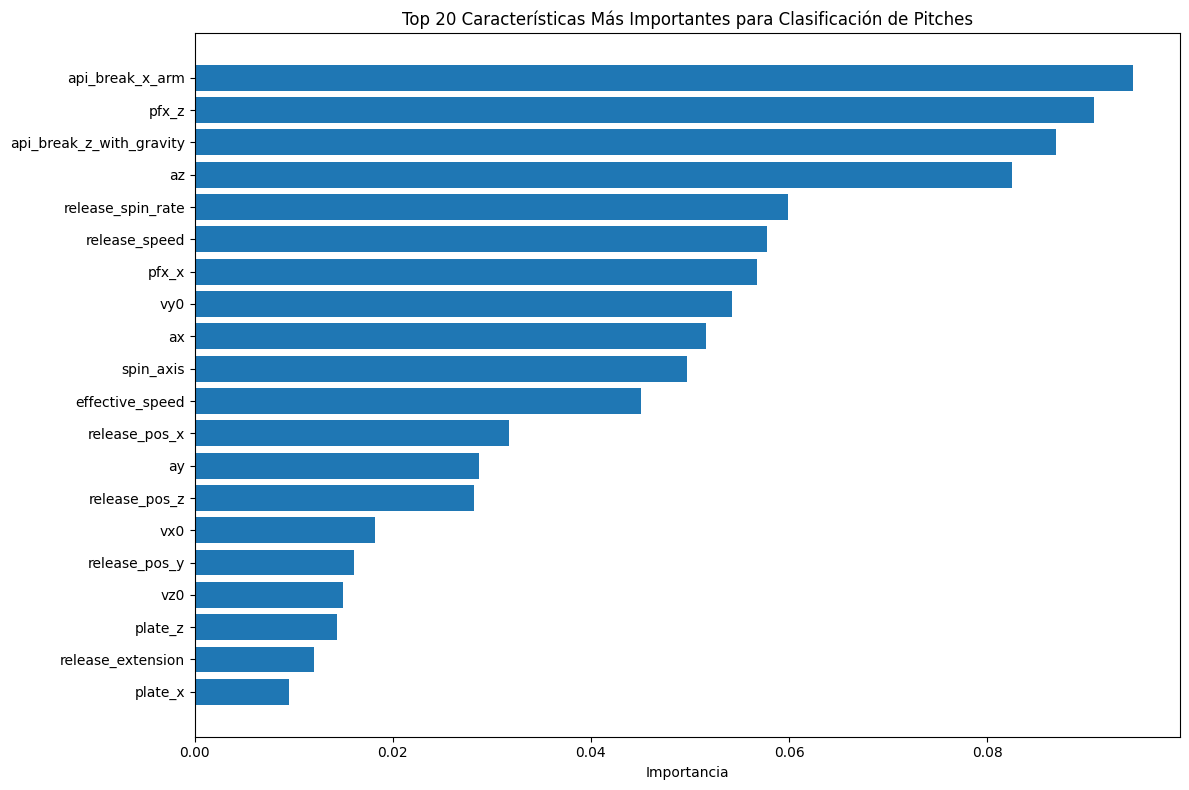

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Obtener importancia de características
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Mostrar top 20 características más importantes
print("=== Top 20 Características Más Importantes ===\n")
print(feature_importance.head(20).to_string(index=False))

# Visualizar
plt.figure(figsize=(12, 8))
plt.barh(range(20), feature_importance.head(20)['importance'].values[::-1])
plt.yticks(range(20), feature_importance.head(20)['feature'].values[::-1])
plt.xlabel('Importancia')
plt.title('Top 20 Características Más Importantes para Clasificación de Pitches')
plt.tight_layout()
plt.show()